<a href="https://colab.research.google.com/github/HAL9K000/wildfires_abound/blob/kh_contrib/Wildfire_Area_Burn_EDA_Analysis_Australia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2019 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Earth Engine Python API Colab Setup

This notebook demonstrates how to setup the Earth Engine Python API in Colab and provides several examples of how to print and visualize Earth Engine processed data.

In [ ]:
%pip install  nbstripout
!nbstripout EE_API_colab_setup.ipynb
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True \
  --to notebook --inplace EE_API_colab_setup.ipynb

In [1]:
from google.colab import files #Saving files to local directory.
from google.colab import drive #Importing Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Installing geetools may be necessary
!pip install earthengine-api geetools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.3 MB/s eta 0:00:00


## Import API and get credentials

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [3]:
import ee

In [4]:
import numpy as np
import pandas as pan

In [5]:
import geemap
import geetools

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [6]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='erdos-dl-wildfire')

## Test the API

Test the API by printing the elevation of Mount Everest.

In [ ]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


Uploading raster and table assets to Earth Engine.


In [ ]:
!earthengine set_project 'erdos-dl-wildfire'
!earthengine authenticate

E0000 00:00:1751041287.927920    2687 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751041287.935089    2687 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Successfully saved project id
E0000 00:00:1751041296.616295    2731 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751041296.623750    2731 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0627 16:21:41.134842 136617432432640 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJEC

In [ ]:
tiff_path = r"/content/gdrive/My Drive/Colab Notebooks/GIS/Data/Wildfires/Australia/fire_for16-21.tif"
!earthengine upload image --asset_id="projects/erdos-dl-wildfire/assets/ausfiredata" --pyramiding_policy="mode" $tiff_path

E0000 00:00:1751041481.744401    3823 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751041481.751773    3823 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0627 16:24:46.493137 138022800490496 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
Invalid Cloud Storage URL: /content/gdrive/My


In [13]:
#
def generate_ROI_mask(country="Australia", state=  None, county=None):
  # Load GAUL level-1 (admin regions like Queensland)
  gaul = ee.FeatureCollection('FAO/GAUL/2015/level0')

  # Filter for {county}, {state}, {country} if they exist.
  filter = [ee.Filter.eq('ADM0_NAME', country)]
  try:
    if county:
            # Use level 2 (county level)
            gaul = ee.FeatureCollection('FAO/GAUL/2015/level2')
            filter.extend([
                ee.Filter.eq('ADM1_NAME', state),
                ee.Filter.eq('ADM2_NAME', county)
            ])
    elif state:
            # Use level 1 (state level)
            gaul = ee.FeatureCollection('FAO/GAUL/2015/level1')
            filter.append(ee.Filter.eq('ADM1_NAME', state))


    qld = gaul.filter(ee.Filter.And(*filter)).geometry()
    return qld
  except Exception as e:
    print(f"Could not find GAUL data for {country}, {state}, {county} with error: {e}")
    return None

In [12]:
def mask_clouds(image):
    # Use pixel QA band to mask clouds and shadows
    qa = image.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(  # Cloud
                 qa.bitwiseAnd(1 << 4).eq(0))      # Shadow
    return image.updateMask(cloud_mask)

def compute_nbr(image):
    # NBR = (NIR - SWIR2) / (NIR + SWIR2)
    # Using Landsat 8 Collection 2 band names
    nbr = image.normalizedDifference(['SR_B5', 'SR_B7']).rename('NBR')
    return image.addBands(nbr)

```calculate_burn_statistics(...)``` Returns Pandas Dataframe of burnt area stats.

In [18]:
"""
Calculate burn area statistics and return as pandas DataFrame.

Args:
    burn_area: Binary burn area image
    region: Region geometry
    year_pair: Year pair string (e.g., '2019-2020')
    burn_threshold: Burn threshold used
    composite_method: Composite method used

Returns:
    pan.DataFrame: Burn statistics with columns for easy analysis
"""

def calculate_burn_statistics(burn_area, ROI: ee.Geometry, year_pair: str, burn_threshold=0.3,composite_method="mean"):

    # Calculate area in hectares
    area_image = burn_area.multiply(ee.Image.pixelArea()).divide(10000)  # Convert to hectares

    # Sum the burned area
    burn_area_result = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=ROI,
        scale=30,  # Landsat pixel size
        maxPixels=1e9, bestEffort=True
    )

    # Get region total area for percentage calculation
    total_area_result = ee.Image(1).multiply(ee.Image.pixelArea()).divide(10000).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=ROI,
        scale=30,
        maxPixels=1e9, bestEffort=True
    )

    # Extract values (these are still ee.ComputedObject at this point)
    #with ee.geetools.Profiler() as p1:
    #if burn_area_result is not None or total_area_result is not None:
    '''
    try:
        # Get the actual values from Earth Engine
        print("Attempting to calculate burnt area stats")
        with ee.geetools.Profiler() as p1:
          burn_area_ha = burn_area_result.getInfo()
        df = pan.DataFrame(p1.profile); print(df.head()); print(df.tail()); print(df.shape); print(df.info()); print(df.describe())

        # Get the actual values from Earth Engine
        print("Attempting to calculate total area stats")
        with ee.geetools.Profiler() as p2:
          total_area_ha = total_area_result.getInfo()
        df = pan.DataFrame(p2.profile); print(df.head()); print(df.tail()); print(df.shape); print(df.info()); print(df.describe())

        # Extract the actual numeric values
        burn_area_value = list(burn_area_ha.values())[0] if burn_area_ha else 0
        total_area_value = list(total_area_ha.values())[0] if total_area_ha else 0

        # Calculate percentage
        burn_percentage = (burn_area_value / total_area_value * 100) if total_area_value > 0 else 0

    except Exception as e:
        print(f"Warning: Could not retrieve burn statistics for {year_pair}: {e}")
        burn_area_value = np.nan
        total_area_value = np.nan
        burn_percentage = np.nan
    #df = pan.DataFrame(p.profile)
    #df.head()
    '''

    # Create DataFrame
    stats_df = pan.DataFrame({
        'year_pair': [year_pair],
    #    'burn_area_ha': [burn_area_value],
    #    'total_area_ha': [total_area_value],
    #    'burn_percentage': [burn_percentage],
        'burn_threshold': [burn_threshold],
        'composite_method': [composite_method]
    })

    return stats_df

In [14]:
def pairwise_year_dNBR(ROI: ee.Geometry, start_year: int =2019, end_year: int=2020,
          wet_season_months: list = [3, 5], dry_season_months: list = [10, 12]):

    pre_fire_start = f'{start_year}-{wet_season_months[0]:02d}-01'
    pre_fire_end = f'{start_year}-{wet_season_months[1]:02d}-01'
    post_fire_start = f'{end_year}-{wet_season_months[0]:02d}-01'
    post_fire_end = f'{end_year}-{wet_season_months[1]:02d}-01'

    landsat_sr = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

    try:
      pre_fire_img = (landsat_sr.filterBounds(ROI)
                          .filterDate(pre_fire_start, pre_fire_end)
                          .map(mask_clouds)
                          .map(compute_nbr)
                          .median()
                          .clip(ROI))

      post_fire_img = (landsat_sr.filterBounds(ROI)
                           .filterDate(post_fire_start, post_fire_end)
                           .map(mask_clouds)
                           .map(compute_nbr)
                           .median()
                           .clip(ROI))

      # Compute dNBR
      dnbr = pre_fire_img.select('NBR').subtract(post_fire_img.select('NBR')).rename('dNBR')

      # Add year metadata
      dnbr = dnbr.set({
          'year_pair': f'{start_year}-{end_year}',
          'pre_fire_year': start_year,
          'post_fire_year': end_year
      })

      return dnbr
    except Exception as e:
      print(f"Could not compute dNBR for {start_year}-{end_year}, with wet seasons: {wet_season_months} with error: {e}")
      return None

In [ ]:
"""
Perform multi-year burn area analysis and return results as DataFrame.

Args:
    country: Country name
    state: State/province name (optional)
    county: County name (optional)
    years: List of years to analyze (consecutive pairs will be used)
    wet_season_months: Tuple of (start_month, end_month) for wet season
    composite_method: Method for compositing multiple years ('mean', 'median', 'max', 'sum')
    burn_threshold: dNBR threshold for burn classification

Returns:
    pan.DataFrame: Analysis results with burn statistics and metadata
"""

def analyze_multiyear_burns(country="Australia", state = "Queensland", county = None,
                           years= [2013, 2025], wet_season_months= (3, 5),
                           composite_method= 'mean', burn_threshold = 0.1):


    if len(years) < 2:
        raise ValueError("At least 2 years are required for analysis")

    # Get region geometry
    region = generate_ROI_mask(country, state, county)

    # Process year pairs and collect statistics
    all_stats = []
    dnbr_images = []

    for i in range(len(years) - 1):
        year1, year2 = years[i], years[i + 1]
        year_pair = f'{year1}-{year2}'

        # Process year pair
        dnbr = pairwise_year_dNBR(region, year1, year2, wet_season_months)
        if dnbr is not None:
          dnbr_images.append(dnbr)
          # Calculate individual year pair burn statistics
          individual_burn_area = dnbr.gt(burn_threshold).selfMask()

          year_stats = calculate_burn_statistics(individual_burn_area, region, year_pair, burn_threshold, 'individual')
          all_stats.append(year_stats)

          print(f"Processed year pair: {year1}-{year2}")
        else:
          print(f"Skipping year pair: {year1}-{year2} due to missing data")

    # Create composite image
    dnbr_collection = ee.ImageCollection(dnbr_images)

    if composite_method == 'mean':
        composite_dnbr = dnbr_collection.mean().rename('dNBR_composite')
    elif composite_method == 'median':
        composite_dnbr = dnbr_collection.median().rename('dNBR_composite')
    elif composite_method == 'max':
        composite_dnbr = dnbr_collection.max().rename('dNBR_composite')
    elif composite_method == 'sum':
        composite_dnbr = dnbr_collection.sum().rename('dNBR_composite')
    else:
        raise ValueError(f"Unknown composite method: {composite_method}")

    # Apply burn threshold to composite
    composite_burn_area = composite_dnbr.gt(burn_threshold).selfMask()

    # Calculate composite statistics
    composite_stats = calculate_burn_statistics(composite_burn_area, region, 'composite', burn_threshold, composite_method)
    all_stats.append(composite_stats)

    # Combine all statistics
    results_df = pan.concat(all_stats, ignore_index=True) #pan.DataFrame() #pan.concat(all_stats, ignore_index=True)

    # Add metadata columns
    results_df['country'] = country
    results_df['state'] = state
    results_df['county'] = county
    results_df['years_analyzed'] = str(years)
    results_df['wet_season_start'] = wet_season_months[0]
    results_df['wet_season_end'] = wet_season_months[1]

    #results_df['analysis_timestamp'] = pan.Timestamp.now()

    # Store the Earth Engine objects for visualization
    results_df.attrs['composite_dnbr'] = composite_dnbr
    results_df.attrs['composite_burn_area'] = composite_burn_area
    results_df.attrs['region'] = region

    print(results_df)

    return results_df

In [ ]:
"""
Creates an interactive map visualization of the burn analysis results.

Args:
    results_df: Results DataFrame from analyze_multiyear_burns
    zoom_level: Initial zoom level for the map

Returns:
    geemap.Map: Interactive map with burn analysis layers
"""

def visualize_results(results_df: pan.DataFrame,
                     zoom_level: int = 8) -> geemap.Map:
    # Extract Earth Engine objects from DataFrame attributes
    composite_dnbr = results_df.attrs['composite_dnbr']
    #composite_burn_area = results_df.attrs['composite_burn_area']
    region = results_df.attrs['region']

    # Get metadata from the composite row
    composite_row = results_df[results_df['year_pair'] == 'composite'].iloc[0]

    # Get map center from region centroid
    center = region.centroid(10).coordinates().getInfo()[::-1]

    # Create map
    Map = geemap.Map(center=center, zoom=zoom_level)

    # Add dNBR layer
    dnbr_vis = {
        'min': -0.5,
        'max': 1,
        'palette': "Set2"
    }
    Map.addLayer(composite_dnbr, dnbr_vis,
                f'dNBR Composite ({composite_row["composite_method"]})')

    # Add burn area layer (self mask for dNBR gt 0.1)
    composite_burn_area_1 = composite_dnbr.gt(composite_row['burn_threshold']).selfMask()
    composite_burn_area_2 = composite_dnbr.gt(composite_row['burn_threshold'] + 0.2).selfMask()
    burn_vis = {'palette': 'violetred'}; burn_vis2 = {'palette': 'black'}
    Map.addLayer(composite_burn_area_1, burn_vis,
                f'Burn Area (threshold: {composite_row["burn_threshold"]})')

    Map.addLayer(composite_burn_area_2, burn_vis,
                f'Burn Area (threshold: {composite_row["burn_threshold"] + 0.2})')

    # Add region boundary
    region_vis = {'color': 'blue', 'fillColor': '00000000', 'width': 2}
    Map.addLayer(region, region_vis, 'Region Boundary')

    # Add layer control
    Map.addLayerControl()

    return Map

def print_burn_summary(results_df: pan.DataFrame):
    """
    Print a summary of burn analysis results.

    Args:
        results_df: Results DataFrame from analyze_multiyear_burns
    """
    print("=== Burn Analysis Summary ===")
    print(f"Country: {results_df['country'].iloc[0]}")
    print(f"State: {results_df['state'].iloc[0] or 'All'}")
    print(f"County: {results_df['county'].iloc[0] or 'All'}")
    print(f"Years: {results_df['years_analyzed'].iloc[0]}")
    print(f"Wet Season: Months {results_df['wet_season_start'].iloc[0]}-{results_df['wet_season_end'].iloc[0]}")
    print()

    # Individual year pairs
    individual_results = results_df[results_df['year_pair'] != 'composite']
    if not individual_results.empty:
        print("Individual Year Pairs:")
        for _, row in individual_results.iterrows():
            print(f"  {row['year_pair']}: {row['burn_area_ha']:.2f} ha ({row['burn_percentage']:.3f}%)")

    # Composite result
    composite_result = results_df[results_df['year_pair'] == 'composite']
    if not composite_result.empty:
        comp_row = composite_result.iloc[0]
        print(f"\nComposite ({comp_row['composite_method']}):")
        print(f"  Total burn area: {comp_row['burn_area_ha']:.2f} ha")
        print(f"  Percentage of region: {comp_row['burn_percentage']:.3f}%")
        print(f"  Burn threshold: {comp_row['burn_threshold']}")


In [ ]:
results_df = analyze_multiyear_burns(
      country='Australia', state='Queensland',
      years=[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025], wet_season_months=(3, 5),
      composite_method='sum', burn_threshold=0.1)

#print_burn_summary(results_df)
Map = visualize_results(results_df, zoom_level=6)

In [29]:
# Get size of results_df in memory
import sys
print(f"Results DataFrame size: {sys.getsizeof(results_df) / 1e6:.2f} MB")

Results DataFrame size: 0.00 MB


In [27]:
Map

Map(center=[-22.49617473424894, 144.4597314108364], controls=(WidgetControl(options=['position', 'transparent_…

OLD CODE

In [ ]:


pre_fire = ('2019-03-01', '2019-04-01')
post_fire = ('2020-03-01', '2020-04-01') # Corrected end date



# Load and filter Landsat 8 SR images (Tier 1) - Changed to Collection 2 Surface Reflectance
landsat_sr = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
#print(landsat_sr)

pre_fire_img = (landsat_sr.filterBounds(queens_AOI)
                          .filterDate(*pre_fire)
                          .map(mask_clouds)
                          .map(compute_nbr)
                          .median()
                          .clip(queens_AOI))

post_fire_img = (landsat_sr.filterBounds(queens_AOI)
                           .filterDate(*post_fire)
                           .map(mask_clouds)
                           .map(compute_nbr)
                           .median()
                           .clip(queens_AOI))

# Compute dNBR
dnbr = pre_fire_img.select('NBR').subtract(post_fire_img.select('NBR')).rename('dNBR')

# Define burn threshold (0.1 to 0.3 = low severity, >0.3 = high severity)
burn_area = dnbr.gt(0.1).selfMask()

# Optional: visualize using geemap
Map = geemap.Map(center=queens_AOI.centroid(10).coordinates().getInfo()[::-1], zoom=10)
Map.addLayer(dnbr, {'min': -0.5, 'max': 1, 'palette': ['white', 'yellow', 'orange', 'red']}, 'dNBR')
Map.addLayer(burn_area, {'palette': 'black'}, 'Burned Area')
Map.addLayerControl()
Map

Map(center=[-22.49617473426755, 144.45973141082249], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
  gaul = ee.FeatureCollection('FAO/GAUL/2015/level2')
  qld = gaul.filter(ee.Filter.And(
      ee.Filter.eq('ADM0_NAME', 'Australia'),
      ee.Filter.eq('ADM1_NAME', 'Queensland')
  )).geometry()

  queens_AOI = qld

## Map visualization

`ee.Image` objects can be displayed to notebook output cells. The following two
examples demonstrate displaying a static image and an interactive map.


### Static image

The `IPython.display` module contains the `Image` function, which can display
the results of a URL representing an image generated from a call to the Earth
Engine `getThumbUrl` function. The following cell will display a thumbnail
of the global elevation model.

In [ ]:
# Import the Image function from the IPython.display module.
from IPython.display import Image

# Display a thumbnail of global elevation.
Image(url = dem.updateMask(dem.gt(0))
  .getThumbURL({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

### Interactive map

The [geemap](https://github.com/gee-community/geemap)
library can be used to display `ee.Image` objects on an interactive
[ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) map.

The following cell provides an example of using the `geemap.Map` object to
display an elevation model.

In [ ]:
# Import the geemap library.
import geemap

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a map object.
m = geemap.Map(center=[20, 0], zoom=3)

# Add the elevation model to the map object.
m.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Display the map.
display(m)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

## Chart visualization

Some Earth Engine functions produce tabular data that can be plotted by
data visualization packages such as `matplotlib`. The following example
demonstrates the display of tabular data from Earth Engine as a scatter
plot. See [Charting in Colaboratory](https://colab.sandbox.google.com/notebooks/charts.ipynb)
for more information.

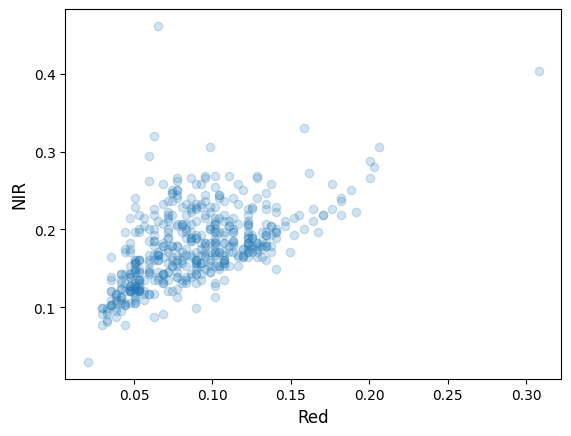

In [ ]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat TOA image.
img = ee.Image('LANDSAT/LT05/C02/T1_TOA/LT05_034033_20000913')

# Select Red and NIR bands and sample 500 points.
samp_fc = img.select(['B3','B4']).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

In [ ]:
print("something", 3+3)

something 6
